In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as sklm

In [2]:
def confusion_matrix(true,pred,labels):
    """ Takes the true and predicted labels and creates a confusion matrix
    annoted with the percent of true values classified in each label"""
    # make a confusion matrix
    cfsn_matrix = sklm.confusion_matrix(true,pred)    
    # determine the distribution of true labels as percentage
    percentage = []
    for array in cfsn_matrix:
        percentage.append((array/np.sum(array))*100)
    # heatmap!
    sns.heatmap(percentage,
            annot=percentage,
            fmt='.0f',
            cmap='viridis',
            cbar=False,
            square=True,
            xticklabels = labels,
            yticklabels = labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def merge_predictions(predict,labels):
    """ Merges the genders and emotions, returns a new dataframe with only 
    the six emotions """
    merged = pd.DataFrame()
    # seperate gender from emotion
    for column in ['predict_emo','true_emo']:
        merged[column] = predict[column].str.split('_',expand=True)[0]
    # swap labels with integers
    merged['true_int'],unique = pd.factorize(merged['true_emo'])
    emo_to_int = dict(zip(unique,range(len(unique))))
    # apply the same swap to predict
    merged['predict_int'] = merged['predict_emo'].replace(emo_to_int)
    return merged, unique

def pre_rec_fsc_scores(true,predict,labels):
    """ Prints accuracy of the model and returns the precision, recall,
    and fscore. """
    accr = sklm.accuracy_score(true,predict)
    print('Model Accuracy: %.2f' % accr)
    prfs = sklm.precision_recall_fscore_support(true,predict)
    scores = pd.DataFrame(prfs,
                          index=['precision','recall','fscore','total_entries'],
                          columns=labels).T
    scores = scores.append(pd.Series(scores.mean(),name='average'))
    scores = scores.round(2)
    scores = scores.drop(columns=['total_entries'])
    return scores
    
def get_predicted_emotions(predict,emo_cols):
    """ returns a dataframe with the highest emotion probability."""
    labels = []
    for index in predict.index:
        entry = predict.loc[index][emo_cols]
        emo_label = entry.sort_values().index[-1]
        labels.append(emo_label)
    predict['predict_emo'] = labels
    return predict
    
def see_predictions(path,merge=False):
    """ take a path and returns a dataframe of scores and displays a 
    confusion matrix."""
    # load csv and extract emotion lables
    predict = pd.read_csv(path,index_col='Unnamed: 0')
    # get highest predicted emotion label
    emo_cols = predict.columns[:len(predict['true_int'].unique())]
    get_predicted_emotions(predict,emo_cols)
    # merge the genders if specified
    if merge == True:
        predict, emo_cols = merge_predictions(predict,emo_cols)
    # make a dataframe containing the scores for each emotion
    scores = pre_rec_fsc_scores(predict['true_int'],predict['predict_int'],emo_cols)
    # call the confusion matrix def    
    confusion_matrix(predict['true_int'],predict['predict_int'],emo_cols)
    return scores

def compare(left_table,right_table,compare=True,lsuffix='left',rsuffix='right'):
    """ joins two datasets and either returns the join or, if specified, a comparison 
    of each column with left - right """
    # join the two tables
    scores = left_table.join(right_table, lsuffix=lsuffix, rsuffix=rsuffix)
    # return based on specified column
    if compare == True:
        comparison = pd.DataFrame()
        for column in ['precision','recall','fscore']:
            comparison[column]=scores[column+lsuffix] - scores[column+rsuffix]
        return comparison
    else:
        return scores

In [3]:
# this is just so I can easily copy and paste the right path
for file in os.listdir('Data/CSVs/'):
    if 'Predictions' in file:
        print("'Data/CSVs/"+file+"'")
        
fig_path = 'Data/Plots/'

'Data/CSVs/Predictions_Avg_Pool.csv'
'Data/CSVs/Predictions_Avg_Pool_Split.csv'
'Data/CSVs/Predictions_Max_Pool.csv'
'Data/CSVs/Predictions_Max_Pool_Split.csv'


# The Test Set
Taking a quick look at the distribution of the test set

fear       308
disgust    304
sad        288
anger      285
happy      277
neutral    269
Name: true_emo, dtype: int64

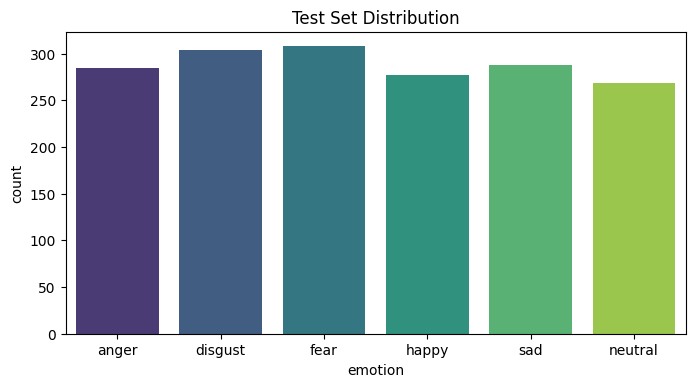

In [6]:
predict = pd.read_csv('Data/CSVs/Predictions_Avg_Pool.csv',index_col='Unnamed: 0')

DIST_TES = plt.figure(figsize=(8,4),dpi=100)
sns.countplot(data=predict,x='true_emo',palette='viridis')
plt.title('Test Set Distribution')
plt.xlabel('emotion')

DIST_TES.savefig(fig_path+'DIST Test Set', bbox_inches='tight');

predict['true_emo'].value_counts()

# Emotion Labels

Model Accuracy: 0.55
Model Accuracy: 0.55


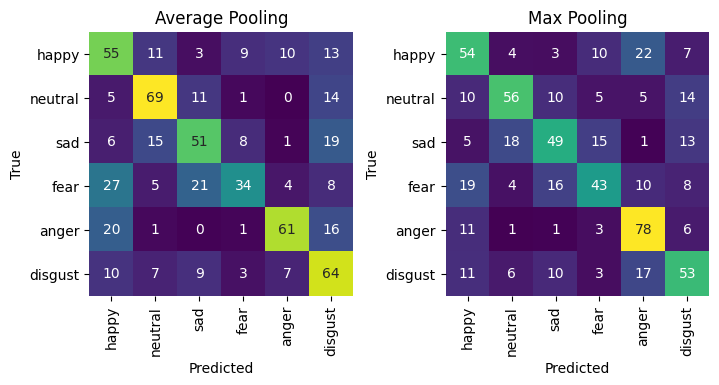

In [12]:
CFM_EMO = plt.figure(figsize=(8,4),dpi=100)
plt.subplots_adjust(wspace=0.35)

plt.subplot(121)
AVG_EM = see_predictions('Data/CSVs/Predictions_Avg_Pool.csv')
plt.title('Average Pooling')

plt.subplot(122)
MAX_EM = see_predictions('Data/CSVs/Predictions_Max_Pool.csv')
plt.title('Max Pooling')

CFM_EMO.savefig(fig_path+'CFM emotion');

In [26]:
compare(AVG_EM,MAX_EM,lsuffix='_AVG_EM',rsuffix='_MAX_EM',compare=False).loc['average']

precision_AVG_EM    0.57
recall_AVG_EM       0.55
fscore_AVG_EM       0.55
precision_MAX_EM    0.55
recall_MAX_EM       0.55
fscore_MAX_EM       0.55
Name: average, dtype: float64

In [20]:
compare(AVG_EM,MAX_EM,lsuffix='_AVG_EM',rsuffix='_MAX_EM')
# Positive means AVG_EM > MAX_EM

,precision,recall,fscore
happy,-0.05,0.01,-0.03
neutral,0.01,0.13,0.07
sad,-0.01,0.02,0.01
fear,0.06,-0.09,-0.05
anger,0.15,-0.17,-0.01
disgust,-0.05,0.11,0.02
average,0.02,0.00,0.00


# Max Pooling

Model Accuracy: 0.55
Model Accuracy: 0.54


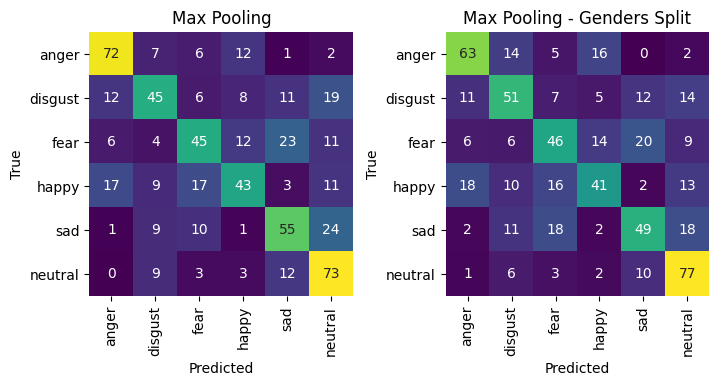

In [21]:
CFM_EMG = plt.figure(figsize=(8,4),dpi=100)
plt.subplots_adjust(wspace=0.35)

plt.subplot(121)
AVG_EG= see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv',merge=True)
plt.title('Max Pooling')

plt.subplot(122)
MAX_EG = see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv',merge=True)
plt.title('Max Pooling - Genders Split')

CFM_EMG.savefig(fig_path+'CFM Emotion_Gender');

In [24]:
compare(AVG_EG,MAX_EG,lsuffix='_AVG_EG',rsuffix='_MAX_EG',compare=False).loc['average']

precision_AVG_EG    0.55
recall_AVG_EG       0.56
fscore_AVG_EG       0.55
precision_MAX_EG    0.54
recall_MAX_EG       0.54
fscore_MAX_EG       0.54
Name: average, dtype: float64

In [15]:
compare(AVG_EG,MAX_EG,lsuffix='_AVG_EG',rsuffix='_MAX_EG')
# positive means that AVG_EG > MAX_EG

,precision,recall,fscore
anger,0.05,0.09,0.06
disgust,0.02,-0.06,-0.02
fear,0.04,-0.01,0.01
happy,0.03,0.02,0.03
sad,0.00,0.06,0.03
neutral,-0.05,-0.04,-0.04
average,0.01,0.02,0.01


# Full Gender Split Matrix

Model Accuracy: 0.52
Model Accuracy: 0.50


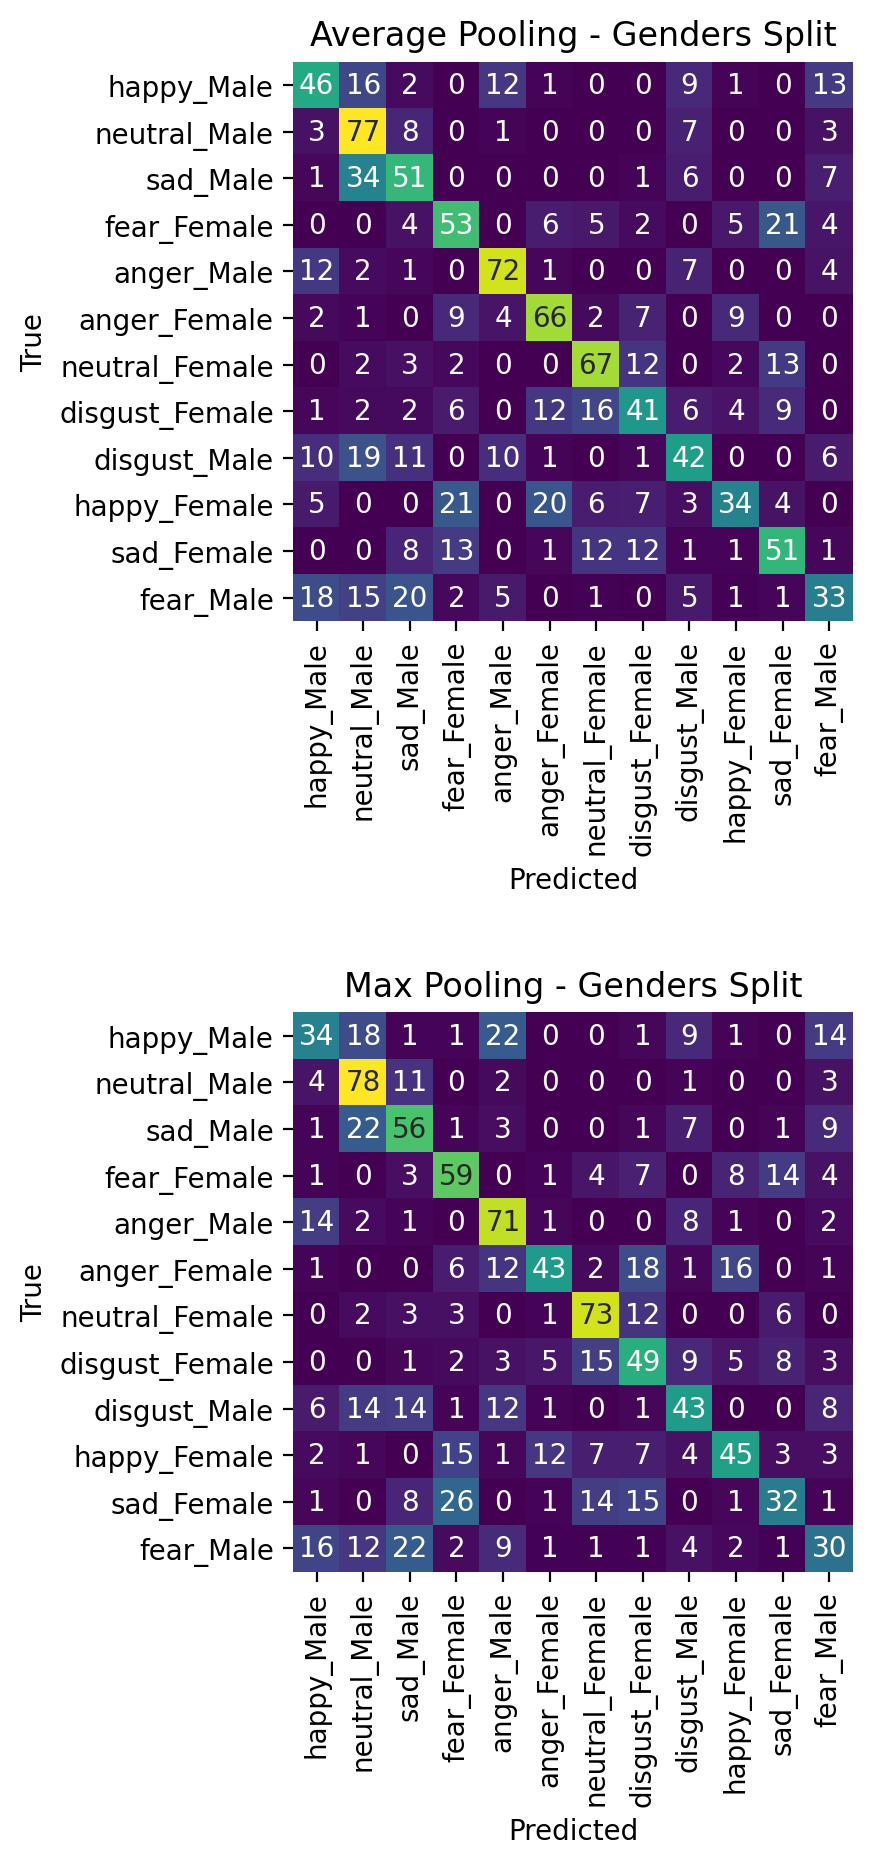

In [27]:
CFM_SGF = plt.figure(figsize=(4,10),dpi=200)
plt.subplots_adjust(hspace=0.7)

plt.subplot(211)
see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv')
plt.title('Average Pooling - Genders Split')

plt.subplot(212)
see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv')
plt.title('Max Pooling - Genders Split')
CFM_SGF.savefig(fig_path+'CFM Full Split');